## Stochastic Processes Project: Lotka Volterra Systems

## Introduction

The three population Lotka-Volterra system of ODEs represents the dynamics of ecological systems involving three interacting species.

The interaction matrix, denoted as ($A$), quantifies the strength and directionality of the species' interactions, whereas the intrinsic growth vector, denoted as ($g$), accounts for the autonomous growth rates of the species. The problem can be represented by the following system:


$$
\begin{align*} \frac{{dx_1}}{{dt}} &= x_1 \left( g_1 + A_{11}x_1 + A_{12}x_2 + A_{13}x_3 \right) \\ 

\frac{{dx_2}}{{dt}} &= x_2 \left( g_2 + A_{21}x_1 + A_{22}x_2 + A_{23}x_3 \right) \\

\frac{{dx_3}}{{dt}} &= x_3 \left( g_3 + A_{31}x_1 + A_{32}x_2 + A_{33}x_3 \right) \ \end{align*}
$$

In this project, we first define methods to solve and visualize solutions for a Lotka-Volterra Initial Value Problem. Then, we proceed to identify fixed points, oscillations, and chaos in such systems.


In [8]:
# Importing libraries
import numpy as np
from scipy.integrate import solve_ivp
from scipy.fft import fft, fftfreq
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import networkx as nx

# Population Dynamics and Phase Plots

We first plot the populations over time and then draw the phase plots.

A phase plot illustrates the behavior of the solution trajectories in the phase space.

The **phase space** is a space where each axis represents a different variable of the ODE. In the phase plot, the **solution trajectories** are curves or paths traced out by the variables over time.

In [15]:
def plot_population_phase(interaction_matrix, initial_populations, growth_rates, t_span, t_eval=None):
    num_species = interaction_matrix.shape$$0]
    
    def dXdt(t, X):
        return growth_rates * X + X * (np.dot(interaction_matrix, X))
    
    sol = solve_ivp(dXdt, t_span, initial_populations, method='RK45', t_eval=t_eval)
     # Plotting population dynamics
    plt.figure(figsize=(12, 6))
    for i in range(num_species):
        plt.plot(sol.t, sol.y$$i], label=f'Species {i+1}')
    plt.title('Population Dynamics Over Time')
    plt.xlabel('Time')
    plt.ylabel('Population')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plotting phase plots for each pair of species
    for i in range(num_species):
        for j in range(i + 1, num_species):
            plt.figure()
            plt.plot(sol.y$$i], sol.y$$j], label=f'Species {i+1} vs Species {j+1}')
            plt.scatter(initial_populations$$i$$, initial_populations$$j], color='red', zorder=5)  # Initial condition marker
            plt.title(f'Phase Plot: Species {i+1} vs Species {j+1}')
            plt.xlabel(f'Species {i+1} Population')
            plt.ylabel(f'Species {j+1} Population')
            plt.legend()
            plt.grid(True)
            plt.show()

## Bifurcation Diagram

A bifurcation diagram showcases the qualitative changes in the behavior of the system as a parameter is varied.

It provides a visual snapshot of the critical parameter values at which qualitative changes occur.



In [3]:
def plot_bifurcation_diagram(interaction_matrix, initial_populations, growth_rates, t_span, parameter_range, varying_index, t_eval=None):
    """
    Generate and plot a bifurcation diagram for the Lotka-Volterra system, by varying one of the growth rates.

    Parameters:
    interaction_matrix (np.array): Interaction matrix.
    initial_populations (list or np.array): Initial population array.
    growth_rates (list or np.array): Growth rates for the species.
    t_span (tuple): Time span for the integration.
    parameter_range (tuple): (start, end, step) for the varying parameter
    varying_index (int): Index of the growth rate to vary.
    t_eval (np.array, optional): Points at which to return the solution."""
    
    start, end, step = parameter_range
    param_values = np.arange(start, end, step)
    long_term_behaviors = []

    for param in param_values:
        # Update the growth rate
        new_growth_rates = np.copy(growth_rates)
        new_growth_rates[varying_index] = param

        # Solve the ODE
        sol = solve_ivp(lambda t, X: X * new_growth_rates + X * (interaction_matrix @ X),
                        t_span, initial_populations, t_eval=t_eval, method='RK45')
        
        # Analyze the solution
        if t_eval is not None and len(sol.y.shape) > 1:  # Use the last 10% of the time points to average
            last_values = sol.y[:, -int(0.1 * len(sol.t)):]
            mean_populations = np.mean(last_values, axis=1)
        else:
            mean_populations = sol.y[:, -1] if len(sol.y.shape) > 1 else sol.y
            
        long_term_behaviors.append(mean_populations)

    long_term_behaviors = np.array(long_term_behaviors).T

    # Plotting the bifurcation diagram
    plt.figure(figsize=(10, 6))
    for i in range(interaction_matrix.shape[0]):
        plt.plot(param_values, long_term_behaviors[i], label=f'Species {i+1}')
    
    plt.title("Bifurcation Diagram")
    plt.xlabel(f"Varying Growth Rate of Species {varying_index + 1}")
    plt.ylabel("Long-term Average Population")
    plt.legend()
    plt.grid(True)
    plt.show()

# # Example Parameters 
# interaction_matrix = np.array([[0, -0.4],
#                                [0.1, 0]])
# initial_populations = [10, 5]
# growth_rates = [1.5, -0.9]
# t_span = (0, 100)
# t_eval = np.linspace(0, 100, 400)

# # Generate Bifurcation Diagram
# plot_bifurcation_diagram(interaction_matrix, initial_populations, growth_rates, t_span, (0.5, 10, 0.01), varying_index=0)

## 3D Trajectory

In [4]:
def plot_3d_lv_system(interaction_matrix, initial_populations, growth_rates, t_span, t_eval=None):
    """
    Plot a 3D representation of a three-species Lotka-Volterra system.

    Parameters:
    interaction_matrix (np.array): 3x3 matrix specifying the inter-species interaction coefficients.
    initial_populations (list): List containing initial populations of each of the three species.
    growth_rates (list): List containing intrinsic growth rates of each species.
    t_span (tuple): Tuple containing the start and end times for the simulation.
    t_eval (np.array, optional): Points at which to return the solution for plotting.
    """
    # Define the Lotka-Volterra differential equations
    def lv_eq(t, X):
        return X * growth_rates + X * (interaction_matrix @ X)

    # Solve the ODE
    sol = solve_ivp(lv_eq, t_span, initial_populations, method='RK45', t_eval=t_eval)

    # 3D Plot
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot(sol.y$$0], sol.y$$1], sol.y$$2])
    ax.set_xlabel('Population Species 1')
    ax.set_ylabel('Population Species 2')
    ax.set_zlabel('Population Species 3')
    ax.set_title('3D Trajectory of Lotka-Volterra System')

    plt.show()

## Velocity Fields

Velocity fields refer to vector fields that depict the direction and magnitude of the velocities of a dynamical system at different points in its phase space.

In [13]:
def plot_3d_velocity_field(interaction_matrix, growth_rates, population_range, resolution=5):
    """
    Plot the 3D velocity field for a three-species Lotka-Volterra system with improved visibility.

    Parameters:
    interaction_matrix (np.array): 3x3 matrix specifying inter-species interaction coefficients.
    growth_rates (list): List containing intrinsic growth rates of each species.
    population_range (tuple): (min_pop, max_pop) defining the range of populations to visualize.
    resolution (int): The number of grid points in each dimension (controls the resolution of the velocity field).
    """
    if interaction_matrix.shape != (3,3) or len(growth_rates) != 3:
        raise ValueError("This function is designed for a three-species system.")

    # Grid setup
    population_values = np.linspace(population_range$$0], population_range$$1], resolution)
    X, Y, Z = np.meshgrid(population_values, population_values, population_values)

    # Compute growth vectors
    U = growth_rates$$0] * X + X * (interaction_matrix$$0, 0] * X + interaction_matrix$$0, 1] * Y + interaction_matrix$$0, 2] * Z)
    V = growth_rates$$1] * Y + Y * (interaction_matrix$$1, 0] * X + interaction_matrix$$1, 1] * Y + interaction_matrix$$1, 2] * Z)
    W = growth_rates$$2] * Z + Z * (interaction_matrix$$2, 0] * X + interaction_matrix$$2, 1] * Y + interaction_matrix$$2, 2] * Z)

    # Normalize for better viewing
    norm = np.sqrt(U**2 + V**2 + W**2)
    U, V, W = U/norm, V/norm, W/norm

    # Create a 3D plot
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.quiver(X, Y, Z, U, V, W, length=2, normalize=True)
    ax.set_xlabel('Population of Species 1')
    ax.set_ylabel('Population of Species 2')
    ax.set_zlabel('Population of Species 3')
    ax.set_title('3D Velocity Field of Lotka-Volterra System')
    plt.show()

In [7]:
def plot_2d_velocity_field_with_heatmap(interaction_matrix, growth_rates, population_range, species_index=2, resolution=50):
    """
    Creates a velocity field with a heatmap for a specified species population and vectors for the other two species.

    Parameters:
    interaction_matrix (np.array): 3x3 matrix specifying inter-species interaction coefficients.
    growth_rates (list): List containing intrinsic growth rates of each species.
    population_range (tuple): (min_pop, max_pop) defining the range of populations to visualize.
    species_index (int): Index of the species to be represented as a heatmap.
    resolution (int): The number of grid points in each dimension.
    """
    X, Y = np.meshgrid(
        np.linspace(population_range[0], population_range[1], resolution),
        np.linspace(population_range[0], population_range[1], resolution)
    )
    
    # Set constant population for the third species based on species_index.
    if species_index == 0:
        Z = np.full_like(X, 5.0)  # Adjust 5.0 to your specific middle population value as necessary.
    elif species_index == 1:
        Z = X
        X = np.full_like(Z, 5.0)
    else:
        Z = Y

    val_idx = [0, 1, 2]
    val_idx.remove(species_index)

    # Assuming species_index=2 for Z heatmap:
    U = growth_rates[val_idx[0]] * X + X * (interaction_matrix[val_idx[0], val_idx[0]] * X + interaction_matrix[val_idx[0], val_idx[1]] * Y + interaction_matrix[val_idx[0], 2] * Z)
    V = growth_rates[val_idx[1]] * Y + Y * (interaction_matrix[val_idx[1], val_idx[0]] * X + interaction_matrix[val_idx[1], val_idx[1]] * Y + interaction_matrix[val_idx[1], 2] * Z)
    
    # Growth rate change for species 'Z'
    W = growth_rates[species_index] * Z + Z * (interaction_matrix[species_index, val_idx[0]] * X + interaction_matrix[species_index, val_idx[1]] * Y + interaction_matrix[species_index, species_index] * Z)

    # Normalize vectors for visualization
    magnitude = np.sqrt(U**2 + V**2)
    U /= magnitude
    V /= magnitude

    # Plotting
    fig, ax = plt.subplots(figsize=(8, 6))
    strm = ax.streamplot(X, Y, U, V, color=magnitude, linewidth=2, cmap=cm.inferno, density=2)
    colorbar_stream = fig.colorbar(strm.lines)
    colorbar_stream.set_label('Magnitude of velocity (speed)')
    cnt = ax.contourf(X, Y, W, levels=25, cmap=cm.coolwarm)
    colorbar_contour = fig.colorbar(cnt, label='Growth rate change for Species {}'.format(species_index + 1))
    ax.set_xlabel('Population of Species {}'.format(val_idx[0] + 1))
    ax.set_ylabel('Population of Species {}'.format(val_idx[1] + 1))
    ax.set_title('Velocity Field and Contour for Species {}'.format(species_index + 1))
    plt.show()

## Full Analysis

In [6]:
def run_lv_full_analysis(interaction_matrix, initial_populations, growth_rates, t_span, population_range, t_eval=None):
    plot_population_phase(interaction_matrix, initial_populations, growth_rates, t_span, t_eval)
    plot_3d_lv_system(interaction_matrix, initial_populations, growth_rates, t_span, t_eval)
    plot_3d_velocity_field(interaction_matrix, growth_rates, population_range)
    plot_2d_velocity_field_with_heatmap(interaction_matrix, growth_rates, population_range)

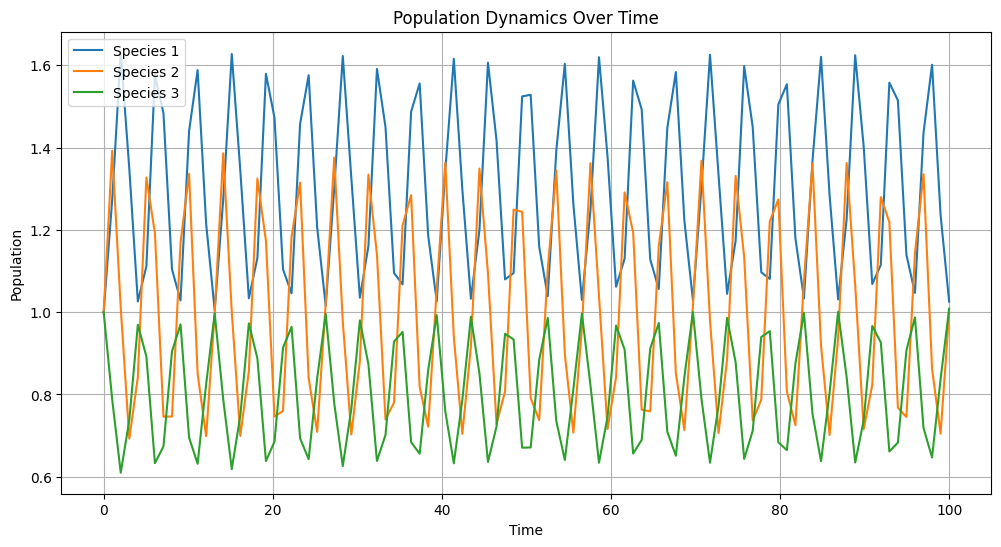

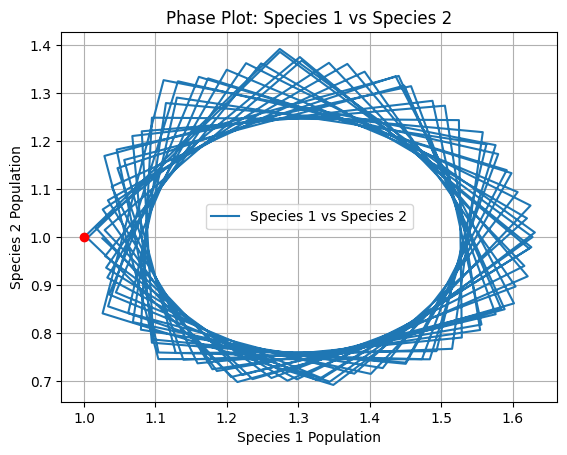

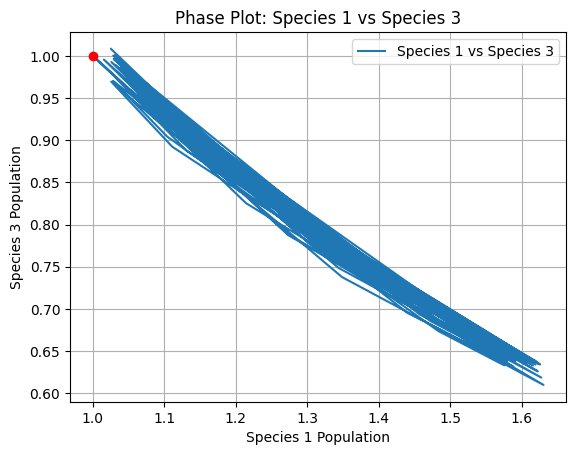

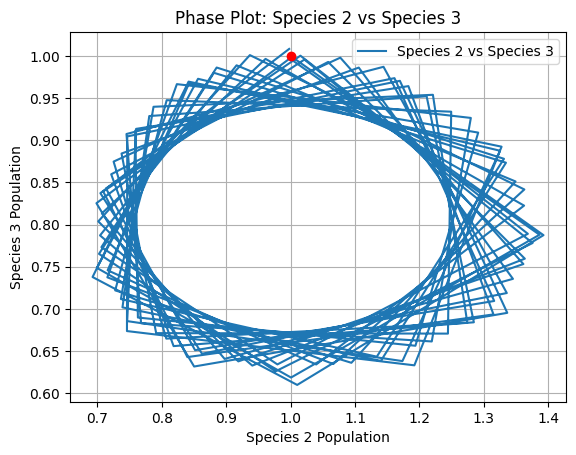

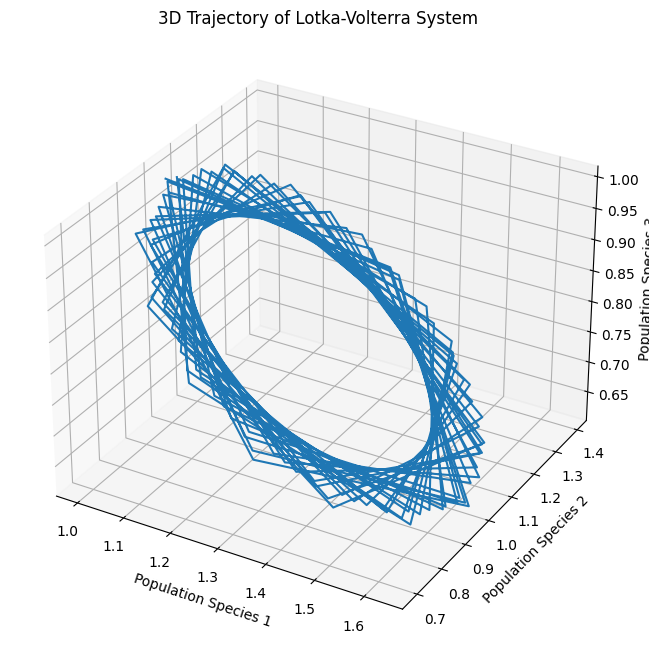

/var/folders/ts/xsr5s4hn2zs46ml6rgb5_42m0000gp/T/ipykernel_45378/615393148.py:25: RuntimeWarning: invalid value encountered in divide
  U, V, W = U/norm, V/norm, W/norm


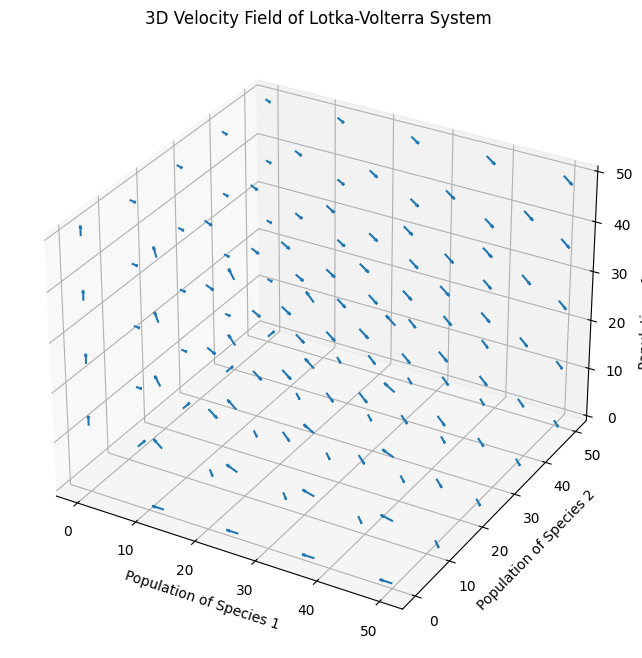

/var/folders/ts/xsr5s4hn2zs46ml6rgb5_42m0000gp/T/ipykernel_45378/881093198.py:38: RuntimeWarning: invalid value encountered in divide
  U /= magnitude
/var/folders/ts/xsr5s4hn2zs46ml6rgb5_42m0000gp/T/ipykernel_45378/881093198.py:39: RuntimeWarning: invalid value encountered in divide
  V /= magnitude


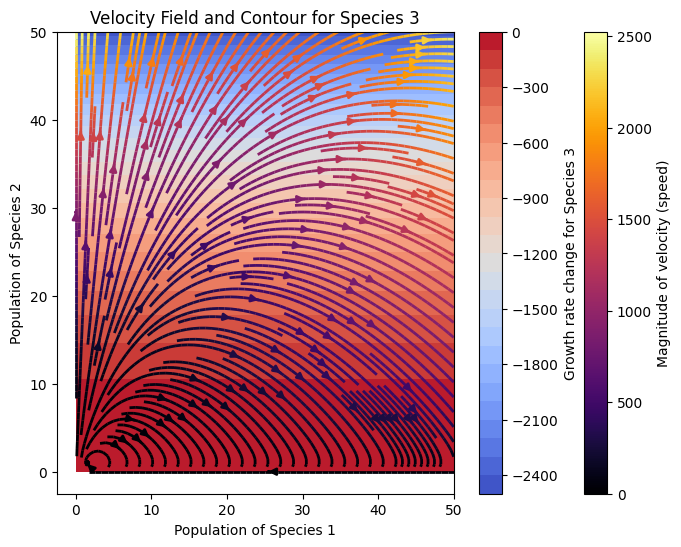

In [14]:
interaction_matrix = np.array($$$$0,  1, 0], 
                              $$-1, 0,  1],
                              $$0,   -1, 0]])

initial_populations = $$1,1,1]
growth_rates = $$-1, .5, 1] 
t_span = (0, 100) 
t_eval = np.linspace(0, 100, 100)
population_range = (0, 50)

run_lv_full_analysis(interaction_matrix, initial_populations, growth_rates, t_span, population_range, t_eval)

## Fixed Points

We divide the fixed points of the model into 4 categories:
- **Trivial**: $x_1 = x_2 = x_3 = 0$
- **Single Species**: $x_i>0$ and $x_j = 0, \forall j \neq i$
- **Two Species**: $x_i=0$ and $x_j > 0, \forall j \neq i$
- **Interior Points**: $x_i > 0, \forall i$

The first two cases are trivial, and we skip their analysis.

### Two Species Fixed Points
WLOG, let $x_3=0$. We then have a two population Lotke-Volterra system.

$$
\begin{align*} \frac{{dx_1}}{{dt}} &= x_1 \left( g_1 + A_{11}x_1 + A_{12}x_2 \right) \\ 

\frac{{dx_2}}{{dt}} &= x_2 \left( g_2 + A_{21}x_1 + A_{22}x_2 \right) \\
\end{align*}
$$

To find the fixed points of the given system of ODEs, we need to solve for the values of $x_1$ and $x_2$ such that both $\frac{{dx_1}}{{dt}}$ and $\frac{{dx_2}}{{dt}}$ are equal to zero.

Setting $\frac{{dx_1}}{{dt}} = 0$, we have:

$$ x_1 \left( g_1 + A_{11}x_1 + A_{12}x_2 \right) = 0 $$

This equation can be satisfied either when $x_1 = 0$ or when the term inside the parentheses equals zero. For the case $x_1 = 0$, the value of $x_2$ can be arbitrary.

When the term inside the parentheses equals zero, we have:

$$ g_1 + A_{11}x_1 + A_{12}x_2 = 0 $$

Solving this equation for $x_2$, we get:

$$ x_2 = \frac{{-g_1 - A_{11}x_1}}{{A_{12}}} $$

Similarly, for $\frac{{dx_2}}{{dt}} = 0$, we have:

$$ x_2 \left( g_2 + A_{21}x_1 + A_{22}x_2 \right) = 0 $$

Again, since $x_2$ cannot be zero, the term inside the parentheses must equal zero:

$$ g_2 + A_{21}x_1 + A_{22}x_2 = 0 $$

Solving this equation for $x_1$, we get:

$$ x_1 = \frac{{-g_2 - A_{22}x_2}}{{A_{21}}} $$

Therefore, the fixed points of the system are given by the pairs $(x_1, x_2)$ that satisfy the simultaneous equations derived above.


To analyze the stability of the fixed point, we need to examine the behavior of the system around the fixed point. We can do this by investigating the eigenvalues of the Jacobian matrix evaluated at the fixed point.

The Jacobian matrix for the given system of ODEs is defined as:

$$J = \begin{bmatrix} \frac{{\partial \frac{{dx_1}}{{dt}}}}{{\partial x_1}} & \frac{{\partial \frac{{dx_1}}{{dt}}}}{{\partial x_2}} \ \frac{{\partial \frac{{dx_2}}{{dt}}}}{{\partial x_1}} & \frac{{\partial \frac{{dx_2}}{{dt}}}}{{\partial x_2}} \end{bmatrix}$$

Evaluating the Jacobian matrix at the fixed point, where $\frac{{dx_1}}{{dt}} = 0$ and $\frac{{dx_2}}{{dt}} = 0$, we have:

$$J = \begin{bmatrix} g_1 + A_{11}x_1 + A_{12}x_2 & A_{12}x_1 \ A_{21}x_2 & g_2 + A_{21}x_1 + A_{22}x_2 \end{bmatrix}$$

To determine the stability of the fixed point, we calculate the eigenvalues of the Jacobian matrix $J$ and analyze their real parts. If all eigenvalues have negative real parts, the fixed point is stable. However, if at least one eigenvalue has a positive real part or there are eigenvalues with zero real parts, the fixed point is unstable or exhibits non-linear behavior.
